#Movie Recommendation and News Integration

Content:

- **⚙️ Data management operations**
  -  Intersection
  -  Deletion
  -  Query


- **📊 Template Creation**
  - Basic Information Search (4 templates)
  - Annual Ranking(3 templates)
  - Film Industry Data News (3 templates)

## Data management operations

#### Connect the database

In [ ]:
from google.colab import drive
drivePath = '/content/drive' #please do not change
drive.mount(drivePath)

dataPath = drivePath + '/MyDrive/Colab Notebooks/data' + "/"

Mounted at /content/drive


In [ ]:
import sqlite3

fileName = "movieRec.db"
db_file_path = dataPath + fileName

# connect the existed database
dbConnection = sqlite3.connect(db_file_path)

if dbConnection:
    dbConnection.close()
    print("Connection closed")

Connection closed


#### Inserting Data (required)



In [ ]:
def create_project(conn, movieInfo):
    """
    Create a new project into the movieInfo table
    :param conn:
    :param project:
    :return: project id
    """
    sql = ''' INSERT INTO movieInfo(movie_id,title,overview,release_date,runtime,budget,revenue,vote_average,vote_count,popularity)
              VALUES(?,?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, movieInfo)
    conn.commit()
    return cur.lastrowid

In [ ]:
fileName = "movieRec.db"
dbConnection = sqlite3.connect(dataPath + fileName)

with dbConnection:
  project = ('10676048','The Marvels', 'Carol Danvers gets her powers entangled with those of Kamala Khan and Monica Rambeau, forcing them to work together to save the universe.', '10/11/2023',
       '105','220000000','114702018','6.1','39000','1');
  project_id = create_project(dbConnection, project)

dbConnection.close()

#### ⚠️Deleting Data (Optional)

In [ ]:
def delete_task(conn, movie_id):
    """
    Delete a movie by movie_id from multiple tables
    :param conn: Connection to the SQLite database
    :param movie_id: id of the movie
    :return:
    """
    tables = ['movieInfo', 'castInfo', 'coList','crewInfo','crtyList','genCatg']
    cur = conn.cursor()
    for table in tables:
        sql = f'DELETE FROM {table} WHERE movie_id=?'
        cur.execute(sql, (movie_id,))
    conn.commit()

In [ ]:
#delete an outlier (movie information in 2017)
fileName = "movieRec.db"
dbConnection = sqlite3.connect(dataPath + fileName)

with dbConnection:
    delete_task(dbConnection, 426469);
dbConnection.close()

In [ ]:
#delete an outlier (movie information in 2017)
fileName = "movieRec.db"
dbConnection = sqlite3.connect(dataPath + fileName)

with dbConnection:
    delete_task(dbConnection, 10676048);
dbConnection.close()

## Template Creation

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display

#### 🟢 **Template 1.1: Movie Info Search**

- User Input:

  - <font color = 'brown'> title

- Output Content:

  _The **{title}** was released on **{date}** in **{crty_name}**. The film was produced by **{company}** and directed by **{director}**. It has already grossed **{revenue}** revenue in total._

In [ ]:
def select_movie_info(conn, title):
    """
    Query movie information including release date, revenue, and country name by title
    :param conn: the Connection object
    :param title: the movie title
    :return: (release_date, revenue, crty_name,co.co_name,crew_name)
    """
    cur = conn.cursor()
    cur.execute("""
        SELECT c.crty_name, mi.release_date, co.co_name, cr.crew_name, mi.revenue
        FROM movieInfo mi
        JOIN crtyList c ON mi.movie_id = c.movie_id
        JOIN coList co ON mi.movie_id = co.movie_id
        LEFT JOIN crewInfo cr ON mi.movie_id = cr.movie_id AND cr.job = 'Director'
        WHERE LOWER(mi.title) = LOWER(?)
    """, (title,))
    row = cur.fetchone()

    if row:
        crty_name=row[0]
        release_date = row[1]
        co_name=row[2]
        crew_name=row[3]
        revenue = round(row[4] / 1000000, 2)
        if crew_name:
            news_sentence = f"The {title} was released on {release_date} in {crty_name}.\n"
            news_sentence += f"The film was produced by {co_name} and directed by {crew_name}.\n"
            news_sentence += f"It has already grossed {revenue} million in total."
        else:
            news_sentence = f"The {title} was released on {release_date} in {crty_name}.\n"
            news_sentence += f"The film was produced by {co_name}.\n"
            news_sentence += f"It has already grossed {revenue} million revenue in total.\n"
            news_sentence += "Director information is not available in the database."

        return news_sentence
    else:
        return None

In [ ]:
fileName = "movieRec.db"
database_file = dataPath + fileName
dbConnection = sqlite3.connect(database_file)

# get the information of movies
with dbConnection:
    title = input('Movie\'s title:')
    result = select_movie_info(dbConnection, title)

    if result:
        print(result)
    else:
        print("Movie not found.")

dbConnection.close()

#### 🟢 **Template 1.2: Single Cast Info Search**

- User Input:

  - <font color = 'brown'> castName

- Output Content:

  _**{castName}** has starred in a total of **{number}** movies. Among them, **{movieName}** achieved the highest revenue of **{amount}** USD, in which the character he/she played is **{characterName1}**. **{movieName}** also has a popularity rate of **{popularity}**, in which the character he/she played is **{characterName2}**. Additionally, **{castName}** has frequently collaborated with **{coStarName}**, and they have acted together in **{coStarNumber}** movie(s)._

In [ ]:
# create a view for future query （don't repeat executed)
fileName = "movieRec.db"
dbConnection = sqlite3.connect(dataPath + fileName)

cursor = dbConnection.cursor()

create_view_sql = ''' CREATE VIEW cast_revenue_popularity AS
    SELECT name,revenue,popularity,title,character,char_order
    FROM castInfo t1, movieInfo t2
    WHERE t1.movie_id= t2.movie_id
    ORDER BY revenue DESC
    '''

cursor.execute(create_view_sql)
dbConnection.commit()

cursor.close()
dbConnection.close()

In [ ]:
# define a function to find total number of movies
def total_movie(conn,name):

  cur = conn.cursor()
  cur.execute('''SELECT count(title)
  FROM cast_revenue_popularity
  WHERE name = ?
  GROUP BY name''', (name,))

  rows = cur.fetchall()
  return rows


# define a function to find the movie with highest revenue
def highest_revenue(conn,name):
  cur = conn.cursor()
  cur.execute('''SELECT title, max(revenue),character
  FROM cast_revenue_popularity
  WHERE name = ?
  LIMIT 1''', (name,))

  rows = cur.fetchall()
  return rows


# define a function to find most popular movie
def most_popular(conn,name):
  cur = conn.cursor()
  cur.execute('''SELECT title, max(popularity),character
  FROM cast_revenue_popularity
  WHERE name = ?
  LIMIT 1''', (name,))

  rows = cur.fetchall()
  return rows


# find the most frequently collaborated co_cast
def coCast(conn,name):
  cur = conn.cursor()
  cur.execute('''SELECT t2.name AS coCast, COUNT(*) AS coCastNumber
  FROM cast_revenue_popularity t1
  JOIN cast_revenue_popularity t2 ON t1.title = t2.title
  WHERE t1.name = ? AND t2.name <> ?
  GROUP BY t2.name
  ORDER BY coCastNumber DESC
  LIMIT 1''',(name,name,))

  rows = cur.fetchall()
  return rows

In [ ]:
fileName = "movieRec.db"
dbConnection = sqlite3.connect(dataPath + fileName)

with dbConnection:
  castName = input('Cast Name:')

  number = total_movie(dbConnection,castName)[0][0]

  revenue_result = highest_revenue(dbConnection,castName)
  if revenue_result:
    movieName1 = revenue_result[0][0]
    amount = round(revenue_result[0][1]/10000000,2)
    charName1= revenue_result[0][2]

  popular_result = most_popular(dbConnection,castName)
  if popular_result:
    movieName2 = popular_result[0][0]
    popularity = round(float(popular_result[0][1]),2)
    charName2= popular_result[0][2]

  coCast_result = coCast(dbConnection,castName)
  if coCast_result:
    coCastName = coCast_result[0][0]
    coCastNum = coCast_result[0][1]

  statement = f'{castName} has starred in a total of {number} movies. \nAmong them, {movieName1} achieved the highest revenue of {amount} million USD, in which the character he/she played is {charName1}. \nAnd {movieName2} has the highest popularity rate of {popularity}, in which the character he/she played is {charName2}. \nAdditionally, {castName} has frequently collaborated with {coCastName}, and they have acted together in {coCastNum} movie(s).'
  print(statement)

dbConnection.close()


Cast Name:Leonardo DiCaprio
Leonardo DiCaprio has starred in a total of 22 movies. 
Among them, Titanic achieved the highest revenue of 184.5 million USD, in which the character he/she played is Jack Dawson. 
And Inception has the highest popularity rate of 167.58, in which the character he/she played is Dom Cobb. 
Additionally, Leonardo DiCaprio has frequently collaborated with Nellie Sciutto, and they have acted together in 3 movie(s).


#### 🟢 **Template 1.3: coCast Info Search**

- User Input:

  - <font color = 'brown'> The First Cast Name
  - <font color = 'brown'> The Second Cast Name

- Output Content:

  _The number of movie that **{actor/actress1}** and **{actor/actress2}** have acted together is **{number}**.
  The first movie they collaborated on was "{movie_title}", which was released on **{release_date}** and directed by **{director}**. The movie's overview is: **{overview}**._

In [ ]:
fileName = "movieRec.db"
dbConnection = sqlite3.connect(dataPath + fileName)

cursor = dbConnection.cursor()

actor1 = input("The First Cast Name：")
actor2 = input("The Second Cast Name：")

query = f"""
SELECT m1.title, m1.overview, m1.release_date, c3.crew_name
FROM movieInfo m1
INNER JOIN castInfo c1 ON m1.movie_id = c1.movie_id
INNER JOIN castInfo c2 ON c1.movie_id = c2.movie_id
INNER JOIN movieInfo m2 ON c2.movie_id = m2.movie_id
INNER JOIN crewInfo c3 ON m1.movie_id = c3.movie_id
WHERE c1.name = '{actor1}' AND c2.name = '{actor2}' AND c3.job = 'Director'
ORDER BY m1.release_date ASC
LIMIT 1;
"""
cursor.execute(query)
result = cursor.fetchone()

if result is None:
    print(f"{actor1} and {actor2} have not acted in a movie together.")
else:
    movie_title, overview, release_date, director = result
    print(f"The number of movie that {actor1} and {actor2} have acted together is 1.")
    print(f"The first movie they collaborated on was \"{movie_title}\", which was released on {release_date} and directed by {director}. \nThe movie's overview is: {overview}")

dbConnection.close()

The First Cast Name：George Lucas
The Second Cast Name：Harrison Ford
The number of movie that George Lucas and Harrison Ford have acted together is 1.
The first movie they collaborated on was "Indiana Jones and the Temple of Doom", which was released on 23/5/1984 and directed by Steven Spielberg. 
The movie's overview is: After arriving in India, Indiana Jones is asked by a desperate village to find a mystical stone. He agrees – and stumbles upon a secret cult plotting a terrible plan in the catacombs of an ancient palace.


#### 🟢 **Template 1.4: Company Info Search**

- User Input:

  - <font color = 'brown'> Company name

- Output Content:

  _Here is the list of movies produced by **{co_name}**. **{title}**_


In [ ]:
def select_coList_info(conn, co_name):
    """
    Query company information including title by company name
    :param co_name: the company name
    :return: a list of title
    """
    cur = conn.cursor()
    cur.execute("""
        SELECT title
        FROM movieInfo
        WHERE movie_id IN (
            SELECT movie_id
            FROM coList
            WHERE co_name = ?)
    """, (co_name,))
    rows = cur.fetchall()
    titles = [row[0] for row in rows]
    return titles

In [ ]:
fileName = "movieRec.db"
database_file = dataPath + fileName
dbConnection = sqlite3.connect(database_file)

with dbConnection:
    co_name = input('please input the company name:')
    title = select_coList_info(dbConnection,co_name)
    if title:
        news_sentence = f"Here is the list of movies produced by {co_name}:\n"
        for title in title:
            news_sentence += f"- {title}\n"
        print(news_sentence)
    else:
        print(f"No movies found for the company {co_name}.")

dbConnection.close()

please input the company name:Walt Disney Pictures
Here is the list of movies produced by Walt Disney Pictures:
- Pirates of the Caribbean: The Curse of the Black Pearl
- Pirates of the Caribbean: Dead Man's Chest
- Pirates of the Caribbean: At World's End
- Inspector Gadget
- The Straight Story
- Monsters, Inc.
- Fantasia
- Aladdin
- Cars
- Pirates of the Caribbean: On Stranger Tides
- National Treasure
- Ratatouille
- The Kid
- Enchanted
- Holes
- The Lion King
- Treasure Planet
- The Santa Clause 2
- Eight Below
- A Bug's Life
- Prince of Persia: The Sands of Time
- Flubber
- The Incredibles
- Mighty Joe Young
- My Favorite Martian
- The Princess Diaries
- Glory Road
- Chicken Little
- The Pacifier
- The Shaggy Dog
- Toy Story 3
- The Princess and the Frog
- Bedtime Stories
- Freaky Friday
- The Muppet Christmas Carol
- Hocus Pocus
- 102 Dalmatians
- Pocahontas
- The Hunchback of Notre Dame
- Dinosaur
- George of the Jungle
- Remember the Titans
- Mulan
- WALL·E
- The Haunted Mansio

#### 🟡 **Template 2.1: Revenue/Budget/Popularity Ranking**

- User Input:

  - <font color = 'brown'> Revenue/Budget/Popularity
  - <font color = 'brown'> Year
  - <font color = 'brown'> Number

- Output Content:

 _There are the TOP **{number}** Movies By **{column}** in **{year}**_

In [ ]:
def globalRk_Y(conn, column, year, number):
    """
    :param conn: the Connection object
    :param column: column to sort by (e.g., 'budget', 'revenue')
    :param year: choose one year
    :param number: choose TOP 10, TOP 50, TOP 100
    :return:
    """

    sql = "SELECT title, {} FROM movieInfo".format(column)
    params = []

    # year para
    if year:
        sql += " WHERE substr(release_date, -4) = ?"
        params.append(year)

    # order para
    sql += " ORDER BY {} DESC LIMIT ?".format(column)
    params.append(number)
    cur = conn.cursor()
    cur.execute(sql, params)

    rows = cur.fetchall()

    column = column.capitalize()
    ranking_df = pd.DataFrame(rows, columns=[column,'Title'])
    ranking_df.sort_values('Title',ascending = True, inplace=True)

    fig = plt.figure(figsize=(6,8))

    if column == 'Revenue':
      plt.barh(ranking_df[column], ranking_df['Title'], color='#00CCCC')
    elif column == 'Budget':
      plt.barh(ranking_df[column], ranking_df['Title'], color='#FF9900')
    else:
      plt.barh(ranking_df[column],ranking_df['Title'], color='#F5C518')

    if year:
      plt.title(f'Top {number} Movies By {column} in {year} ')
    else:
      plt.title(f'Top {number} Movies By {column} for All Years ')

    plt.xticks(rotation=90)
    plt.show()

Revenue/Budget/Popularity:revenue
Year:2011
Top 10/15/30/50:10
🎬 There are the TOP 10 Movies By Revenue in 2011


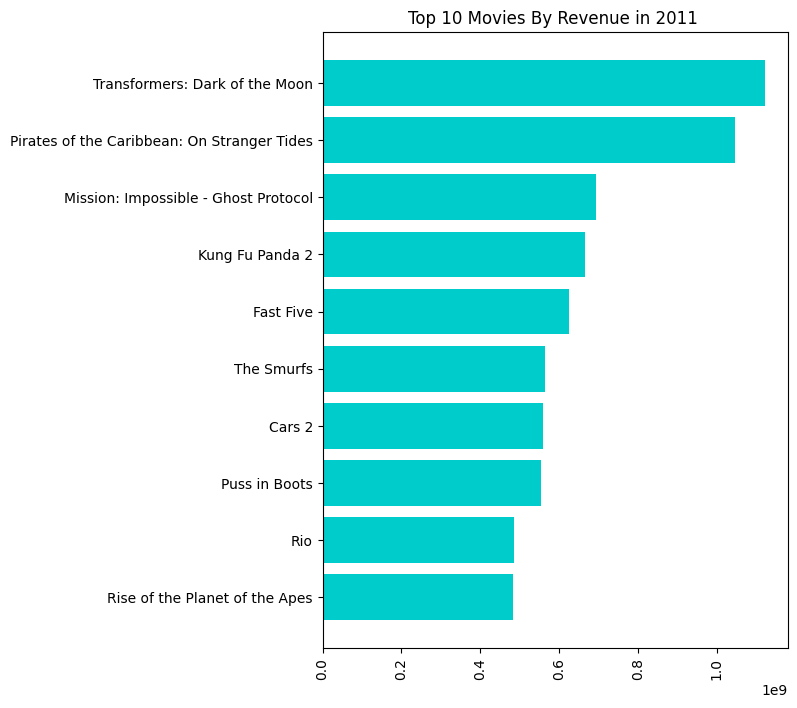

In [ ]:
fileName = "movieRec.db"
dbConnection = sqlite3.connect(dataPath + fileName)

with dbConnection:
  #print('You could view these ranks: Top 10/30/50 Movies By Revenue/Budget/Ratings')
  column = input('Revenue/Budget/Popularity:').capitalize()
  year = input('Year:')
  number = int(input('Top 10/15/30/50:'))

  if year:
    print(f'🎬 There are the TOP {number} Movies By {column} in {year}')
  else:
    print(f'🎬 There are the TOP {number} Movies By {column} for All Years')

  globalRk_Y(dbConnection, column, year, number)

dbConnection.close()

#### 🟡 **Template 2.2: Most Active Cast Ranking**

- User Input:

  - <font color = 'brown'> Year
  - <font color = 'brown'> Number

- Output Content:

 _Top **{number}** Most Active Cast in **{year}**_

In [ ]:
def globalRk_C(conn, year, number):
    """
    Query all rows in the movieInfo table
    :param conn: the Connection object
    :param year: choose one year
    :param number: choose TOP 10, TOP 50, TOP 100
    :return:
    """
    sql = """
    SELECT name, count(name) as movieNum
    FROM castInfo t1, movieInfo t2
    WHERE t1.movie_id = t2.movie_id
    """
    if year:
        sql += "AND substr(release_date, -4) = ? "
    sql += """
    GROUP BY name
    ORDER BY movieNum DESC
    LIMIT ?
    """
    cur = conn.cursor()
    if year:
        cur.execute(sql, (year, number,))
    else:
        cur.execute(sql, (number,))

    rows = cur.fetchall()
    ranking_df = pd.DataFrame(rows, columns=['castName','Number of movies'])

    display(ranking_df)

    return ranking_df

In [ ]:
fileName = "movieRec.db"
dbConnection = sqlite3.connect(dataPath + fileName)

with dbConnection:
  year = input('Year:')
  number = int(input('Top 10/15/30/50:'))

  if year:
    print(f'Top {number} Most Active Cast in {year}')
  else:
    print(f'Top {number} Most Active Cast in All Year')

  globalRk_C(dbConnection, year, number)

dbConnection.close()

Year:2003
Top 10/15/30/50:30
Top 30 Most Active Cast in 2003


,castName,Number of movies
0,Luke Wilson,5
1,Giovanni Ribisi,5
2,Shia LaBeouf,4
3,Seann William Scott,4
4,Monica Bellucci,4
5,Kirby Heyborne,4
6,Eva Mendes,4
7,Eugene Levy,4
8,Cheech Marin,4
9,Anthony Anderson,4


#### 🟡 **Template 2.3: Popular Genre by Year**

- User Input:

  - <font color = 'brown'> Year

- Output Content:

  _Popular Genre in **{Year}**_

In [ ]:
def popularGenre(conn, year):

    cur = conn.cursor()
    cur.execute('''SELECT gen_name, count(gen_name) genNum
    FROM movieInfo t1, genCatg t2
    WHERE t1.movie_id = t2.movie_id  AND substr(release_date, -4)  = ?
    GROUP by  substr(release_date, -4) , gen_name
    HAVING count(gen_name)
    order by substr(release_date, -4)''', (year,))

    rows = cur.fetchall()
    df = pd.DataFrame(rows, columns=['genre_name', 'genNum'])

    data = dict(zip(df['genre_name'], df['genNum']))

    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(data)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.title(f'Popular Genre in {year}',size=12)
    plt.show()

Year:2003


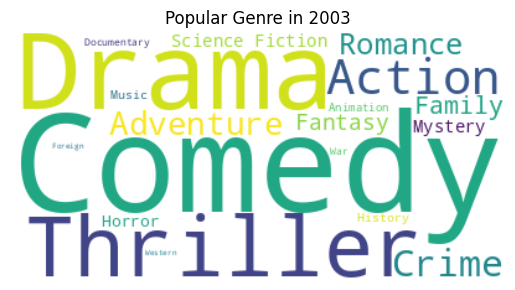

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator

fileName = "movieRec.db"
dbConnection = sqlite3.connect(dataPath + fileName)

with dbConnection:
  year = input('Year:')
  popularGenre(dbConnection, year)

dbConnection.close()

#### 🔵 **Template 3.1: Movie Production Trend by Country, Genre**

- User Input:

  - <font color = 'brown'> Country
  - <font color = 'brown'> Genre

- Output Content:

  _This is the **{genre}** movie trend in **{country}** from 1916 to 2016_

In [ ]:
def movieNum_Trend(conn, country, genre):

    cur = conn.cursor()

    if len(country) == 2:
      if genre:
          cur.execute('''
              SELECT substr(release_date, -4) AS year, count(t1.movie_id) AS movieNum
              FROM movieInfo t1
              JOIN crtyList t2 ON t1.movie_id = t2.movie_id
              JOIN genCatg t3 ON t1.movie_id = t3.movie_id
              WHERE (t2.crty_id = ?)
              AND gen_name = ?
              GROUP BY year
          ''', (country.upper(), genre,))
      else:
          cur.execute('''
              SELECT substr(release_date, -4) AS year, count(t1.movie_id) AS movieNum
              FROM movieInfo t1
              JOIN crtyList t2 ON t1.movie_id = t2.movie_id
              WHERE (t2.crty_id = ?)
              GROUP BY year
          ''', (country.upper(),))
    else:
        if genre:
            cur.execute('''
                SELECT substr(release_date, -4) AS year, count(t1.movie_id) AS movieNum
                FROM movieInfo t1
                JOIN crtyList t2 ON t1.movie_id = t2.movie_id
                JOIN genCatg t3 ON t1.movie_id = t3.movie_id
                WHERE (t2.crty_name = ?)
                AND gen_name = ?
                GROUP BY year
            ''', (country, genre,))
        else:
            cur.execute('''
                SELECT substr(release_date, -4) AS year, count(t1.movie_id) AS movieNum
                FROM movieInfo t1
                JOIN crtyList t2 ON t1.movie_id = t2.movie_id
                WHERE (t2.crty_name = ?)
                GROUP BY year
            ''', (country,))

    rows = cur.fetchall()
    movie_df = pd.DataFrame(rows, columns=['year', 'movieNum'])

    plt.figure(figsize=(10, 6))
    plt.plot(movie_df['year'], movie_df['movieNum'], color='#00CCCC')
    plt.xlabel('Year')
    plt.ylabel('Movie Count')

    if genre:
        plt.title(f'{genre} movie trend in {country} from 1916 to 2016')
    else:
        plt.title(f'Movie Production trend in {country} from 1916 to 2016')

    plt.xticks(movie_df.index[::5], movie_df['year'][::5])
    plt.show()

    return rows

In [ ]:
fileName = "movieRec.db"
dbConnection = sqlite3.connect(dataPath + fileName)

with dbConnection:
    while True:
        try:
            country = input('Country:')
            if not country:
                raise ValueError("Please enter a country.")

            genre = input('Genre:').capitalize()

            rows = movieNum_Trend(dbConnection, country, genre)
            if not rows:
                print("Oops! There is no result. Please try again.")
                continue

            break

        except ValueError as e:
            print(str(e))


        except TypeError as e:
            print("Oops! An error occurred. Please try again.")
            continue

dbConnection.close()

#### 🔵 **Template 3.2: Total Revenue by Genre, Year**

- User Input:

  - <font color = 'brown'> Year
  - <font color = 'brown'> Genre

- Output Content:

 _In **{year}**, the global **{genres}** movie revenue reached **{revenue data}** dollars, which represents a YoY **{increase/decrease}** of **{percentage}** compared to **{last_year}** with a total revenue of **{revenue}** dollars. Among the films released, the top 5 highest-revenue films were **{title}**._

In [ ]:
def select_revenue_and_top_movies(conn, genre, years):
    """
    Query total revenue and top five movies with given genre and release_date in given years
    :param conn: the Connection object
    :param genre: genre name
    :param years: list of release years
    :return: dictionary where key is year and value is a tuple of total revenue and list of top movies
    """
    results = {}
    cur = conn.cursor()
    for year in years:
        # 查询总收入
        cur.execute("""
          SELECT SUM(revenue)
          FROM movieInfo
          JOIN genCatg ON genCatg.movie_id = movieInfo.movie_id
          WHERE genCatg.gen_name=? AND movieInfo.release_date LIKE ?""", (genre, f"%{year}"))

        revenue = cur.fetchone()[0]
        if revenue is None:
            revenue = 0
        total_revenue = int(revenue / 1000000)

        # 查询排名前5的电影名称
        cur.execute("""
          SELECT title
          FROM movieInfo
          JOIN genCatg ON genCatg.movie_id = movieInfo.movie_id
          WHERE genCatg.gen_name=? AND movieInfo.release_date LIKE ?
          ORDER BY movieInfo.revenue DESC
          LIMIT 5""", (genre, f"%{year}"))

        top_movies = cur.fetchall()
        top_movies_names = [movie[0] for movie in top_movies]

        results[year] = (total_revenue, top_movies_names)

    return results

In [ ]:
fileName = "movieRec.db"
dbConnection = sqlite3.connect(dataPath + fileName)

genre = input('Genre: ').capitalize()
year1 = int(input('Year: '))
year2 = year1 - 1

results = select_revenue_and_top_movies(dbConnection, genre, [year1, year2])
revenues = results[year1]
change = revenues[0] - results[year2][0]
percentage_change = (change / results[year2][0]) * 100
change_word = "increase" if change > 0 else "decrease"

print(f"In {year1}, the global {genre} movie revenue reached {revenues[0]} million dollars, which represents a YoY {change_word} of {percentage_change:.2f}% compared to {year2} with a total revenue of {results[year2][0]} million dollars.")
print(f"The top 5 movies in {year1} with the {genre} genre are:")
for movie_name in revenues[1]:
    print(movie_name)

dbConnection.close()

Genre: ACTION
Year: 2004
In 2004, the global Action movie revenue reached 5711 million dollars, which represents a YoY decrease of -22.74% compared to 2003 with a total revenue of 7392 million dollars.
The top 5 movies in 2004 with the Action genre are:
Spider-Man 2
The Incredibles
The Day After Tomorrow
Shark Tale
National Treasure


#### 🔵 **Template 3.3: Total Revenue by Country**

- User Input:

  - <font color = 'brown'> Year
  - <font color = 'brown'> Country

- Output Content:

  _In **{year}**, the total movie revenue in **{country}**  reached **{revenue data}** dollars, which represents a YoY **{increase/decrease}** of **{percentage}** compared to **{last year}** with a total revenue of **{revenue}** dollars. Among the films released, the top 5 highest-revenue films were **{title}**._


In [ ]:
def get_revenue_data(year, country):

    conn = sqlite3.connect('/content/drive/MyDrive/Colab Notebooks/data/movieRec.db')

    cursor = conn.cursor()

    query = f'''
    SELECT SUM(movieInfo.revenue) as total_revenue, COUNT(movieInfo.movie_id) as num_movies
    FROM movieInfo
    JOIN crtyList ON movieInfo.movie_id = crtyList.movie_id
    WHERE (crtyList.crty_name = '{country}' OR crtyList.crty_id = '{country}') AND SUBSTR(movieInfo.release_date, -4) = '{year}'
    '''

    cursor.execute(query)
    result = cursor.fetchone()

    query = f'''
    SELECT SUM(movieInfo.revenue) as total_revenue
    FROM movieInfo
    JOIN crtyList ON movieInfo.movie_id = crtyList.movie_id
    WHERE (crtyList.crty_name = '{country}' OR crtyList.crty_id = '{country}') AND SUBSTR(movieInfo.release_date, -4) = '{int(year) - 1}'
    '''

    cursor.execute(query)
    last_year_result = cursor.fetchone()

    query = f'''
    SELECT movieInfo.title
    FROM movieInfo
    JOIN crtyList ON movieInfo.movie_id = crtyList.movie_id
    WHERE (crtyList.crty_name = '{country}' OR crtyList.crty_id = '{country}') AND SUBSTR(movieInfo.release_date, -4) = '{year}'
    ORDER BY movieInfo.revenue DESC
    LIMIT 5
    '''
    cursor.execute(query)
    top_movies = cursor.fetchall()

    conn.close()

    return result, last_year_result, top_movies

def main():
    year = input("Year: ")
    country = input("Country: ").upper()
    #输入是完整输入（国家可缩写）
    revenue_data, last_year_data, top_movies = get_revenue_data(year, country)

    if revenue_data and last_year_data:
        revenue = round(revenue_data[0]/1000000)
        last_year_revenue = round(last_year_data[0]/1000000)
        percentage = ((revenue - last_year_revenue) / last_year_revenue) * 100
        increase_or_decrease = "increase" if percentage >= 0 else "decrease"
        percentage = abs(percentage)
        top_movies_str = ', '.join([movie[0] for movie in top_movies])

        print(f"In {year}, the total movie revenue in {country} reached {revenue} million dollars, which represents a YoY {increase_or_decrease} of {percentage:.2f}% compared to {int(year) - 1} with a total revenue of {last_year_revenue} million dollars. \nAmong the films released, the top 5 highest-revenue films were: {top_movies_str}")

if __name__ == "__main__":
    main()

Year: 2015
Country: US
In 2015, the total movie revenue in US reached 22074 million dollars, which represents a YoY decrease of 5.63% compared to 2014 with a total revenue of 23390 million dollars. 
Among the films released, the top 5 highest-revenue films were: Jurassic World, Furious 7, Avengers: Age of Ultron, Minions, Spectre
